In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import stats # a script written for performing statistical analysis
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
# load the dataset as dataframe
df = pd.read_csv('response_data.csv', parse_dates=[0, 1]) # turn first 2 columns into datetime type

# calculate the match time for each order
df['match_time'] = df['Driver Response Timestamp'] - df['Order Create Timestamp']

# create an additional column on order match time for analysis (float)
df['total_seconds'] = df['match_time'].dt.total_seconds()

# create a column on time lag between each order
df['order_time_lag'] = df['Order Create Timestamp'].diff().astype('<m8[s]')
df.loc[0, 'order_time_lag'] = 0 # set the first observation as 0

# create a categorical column on weekday name
df['day_of_week'] = df['Order Create Timestamp'].dt.weekday_name.astype('category')

# create a categorical column on sessions in a day
df = df.assign(session=pd.cut(x=df['Order Create Timestamp'].dt.hour, 
                                         bins=[0,6,12,18,24], 
                                         labels=['Night','Morning','Afternoon','Evening']))

# sanity check on general data cleanliness and readiness
df.info()
print('\n')
print(df.head()) # a glimpse of the first 5 observations

# sanity check on duplicated values
print('\n')
print('The data set has {} duplicated observations.'.format(sum(df.duplicated())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
Driver Response Timestamp    5000 non-null datetime64[ns]
Order Create Timestamp       5000 non-null datetime64[ns]
Order Id                     5000 non-null int64
match_time                   5000 non-null timedelta64[ns]
total_seconds                5000 non-null float64
order_time_lag               5000 non-null float64
day_of_week                  5000 non-null category
session                      5000 non-null category
dtypes: category(2), datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 244.8 KB


  Driver Response Timestamp Order Create Timestamp  Order Id match_time  \
0       2017-03-24 22:58:31    2017-03-24 22:57:38         1   00:00:53   
1       2017-03-25 01:04:53    2017-03-25 01:04:53         2   00:00:00   
2       2017-03-25 01:06:16    2017-03-25 01:06:16         3   00:00:00   
3       2017-03-25 01:08:40    2017-03-25 01:07:03        

# Exploratory Data Analysis (Preliminary Investigation)

In [3]:
# a summary of the statistics of order match time
df['total_seconds'].describe()

count    5000.000000
mean       48.891200
std       212.811331
min         0.000000
25%         9.000000
50%        12.000000
75%        26.000000
max      4102.000000
Name: total_seconds, dtype: float64

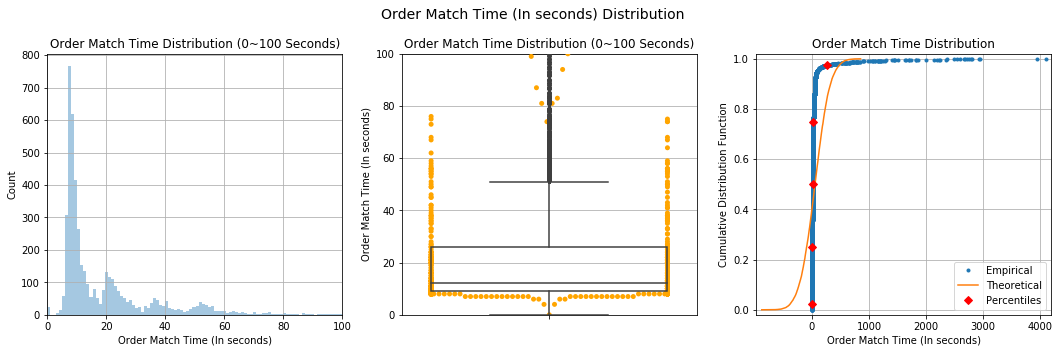

In [4]:
### A visualization of the distribution of order match time (In seconds)

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# a histogram of order match time distribution (0~100 seconds)
sns.distplot(df['total_seconds'], ax=axes[0], kde=False, bins=4000)
axes[0].set_xlim([0, 100])
axes[0].set_title('Order Match Time Distribution (0~100 Seconds)')
axes[0].set_xlabel('Order Match Time (In seconds)')
axes[0].set_ylabel('Count')
axes[0].xaxis.grid(True, which='both')
axes[0].yaxis.grid(True, which='both')

# a boxplot and swarmplot(Subset) of order match time distribution (0~100 seconds)
sns.boxplot(y='total_seconds', data=df, ax=axes[1], boxprops={'facecolor':'None', "zorder":10}, 
            zorder=25, showfliers=True)
sns.swarmplot(y='total_seconds', data=df.sample(500), ax=axes[1], color='orange')
axes[1].set_ylim([0, 100])
axes[1].set_title('Order Match Time Distribution (0~100 Seconds)')
axes[1].set_ylabel('Order Match Time (In seconds)')
axes[1].yaxis.grid(True, which='both')

# the mean & standard deviation of order match time
mu_ts = np.mean(df['total_seconds']) # the mean of order match time
sigma_ts = np.std(df['total_seconds']) # the standard deviation of order match time

# sample out of a normal distribution with the mean & standard deviation
samples_ts = np.random.normal(mu_ts, sigma_ts, size=10000)

# generate CDF for the samples and data set
x_ts, y_ts = stats.ecdf(df['total_seconds']) # actual data set (Empirical)
x_ts_theor, y_ts_theor = stats.ecdf(samples_ts) # normal distribution (Theoretical)

# specify array of percentiles
percentiles = np.array([2.5, 25, 50 ,75, 97.5])

# compute percentiles of order match time
ptiles_ts = np.percentile(df['total_seconds'], percentiles)

# a comparison plot between empirical & theoretical cumulative distribution function of order match time
axes[2].plot(x_ts, y_ts, marker='.', linestyle='none') # actual data set (Empirical)
axes[2].plot(x_ts_theor, y_ts_theor) # normal distribution (Theoretical)
axes[2].plot(ptiles_ts, percentiles/100, marker='D', color='red', linestyle='none')
axes[2].set_title('Order Match Time Distribution')
axes[2].set_xlabel('Order Match Time (In seconds)')
axes[2].set_ylabel('Cumulative Distribution Function')
axes[2].xaxis.grid(True, which='both')
axes[2].yaxis.grid(True, which='both')
axes[2].legend(('Empirical', 'Theoretical', 'Percentiles'), loc='lower right')
axes[2].margins(0.02)

# figure parameters
fig.suptitle('Order Match Time (In seconds) Distribution', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

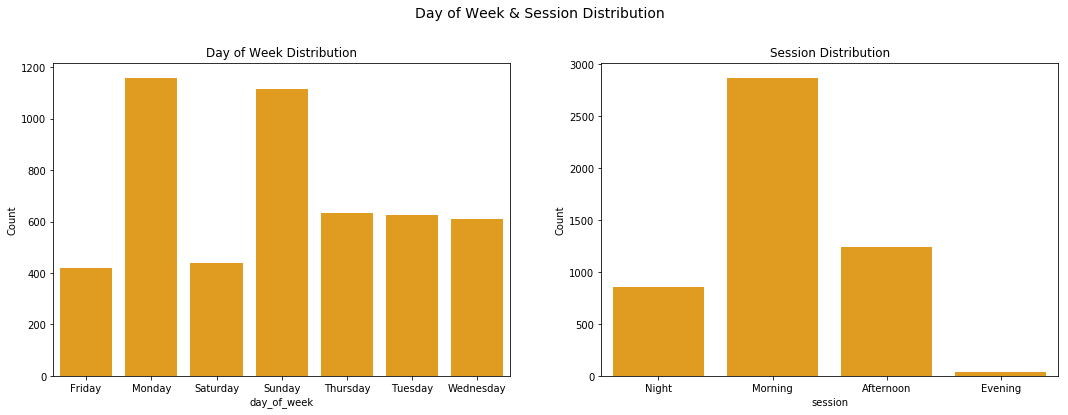

In [5]:
### A visualization of the distribution of Day of Week and Session

# create subplots
fig, axes = plt.subplots(1, 2, figsize=[18,6])

# plot parameters
columns = ['day_of_week', 'session']
titles = ['Day of Week Distribution', 'Session Distribution']

# a loop for visualization
for idx, column in enumerate(zip(columns, titles)):
    sns.countplot(x=column[0], data=df, ax=axes[idx], color='orange')
    axes[idx].set_xlabel(column[0])
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(column[1])

# figure parameters
fig.suptitle('Day of Week & Session Distribution', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

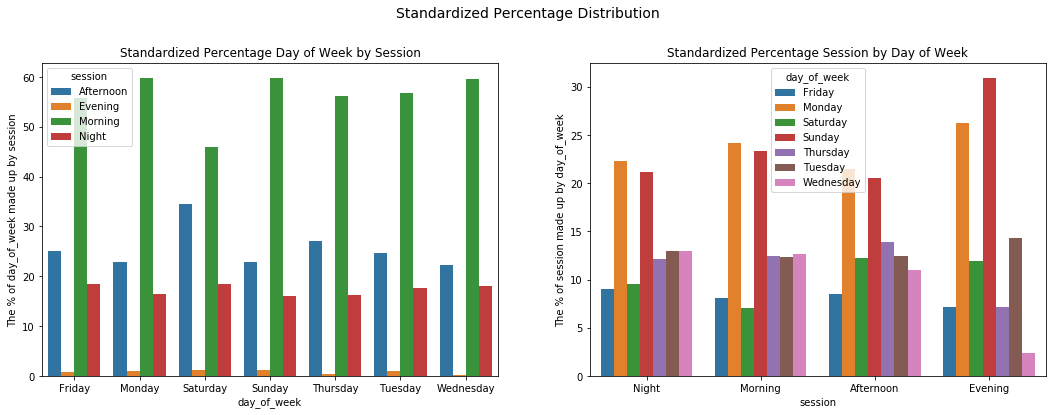

In [6]:
### A visualization of the standardized percentage distribution of Day of Week and Session

# create subplots
fig, axes = plt.subplots(1, 2, figsize=[18,6])

# plot parameters
columns = ['day_of_week', 'session']
hue = ['session', 'day_of_week']
titles = ['Standardized Percentage Day of Week by Session', 'Standardized Percentage Session by Day of Week']

# a loop for visualization
for idx, column in enumerate(zip(columns, hue, titles)):
    stats.pct_std_barplot(x=column[0], y='Percentage', hue=column[1], data=df, ax=axes[idx])
    axes[idx].set_xlabel(column[0])
    axes[idx].set_ylabel('The % of {} made up by {}'.format(column[0], column[1]))
    axes[idx].set_title(column[2])

# figure parameters
fig.suptitle('Standardized Percentage Distribution', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

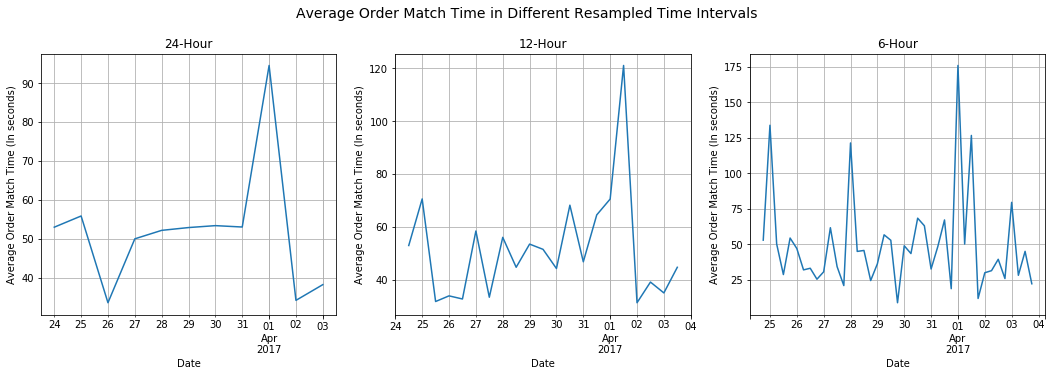

In [7]:
### A visualization on different resampled time intervals (Average order match time)

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot parameters
intervals = ['D', '12H', '6H']
titles = ['24-Hour', '12-Hour', '6-Hour']

# a loop for visualization
for idx, interval in enumerate(zip(intervals, titles)):
    # resample data based on order create time and perform aggregation to get the average
    df.set_index('Order Create Timestamp')['total_seconds'].resample(interval[0]).mean().plot(ax=axes[idx])
    axes[idx].set_title(interval[1])
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Average Order Match Time (In seconds)')
    axes[idx].xaxis.grid(True, which='both')
    axes[idx].yaxis.grid(True, which='both')

# figure parameters
fig.suptitle('Average Order Match Time in Different Resampled Time Intervals', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

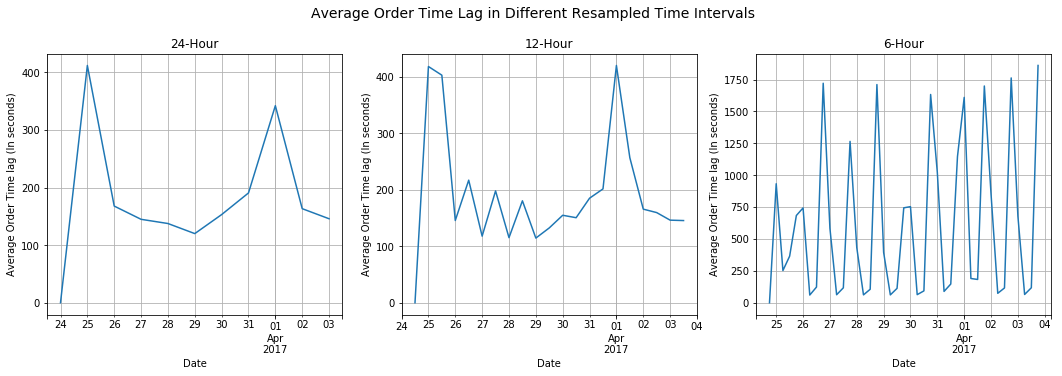

In [8]:
### A visualization on different resampled time intervals (Average order time lag)

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot parameters
intervals = ['24H', '12H', '6H']
titles = ['24-Hour', '12-Hour', '6-Hour']

# a loop for visualization
for idx, interval in enumerate(zip(intervals, titles)):
    # resample data based on order create time and perform aggregation to get the average
    df.set_index('Order Create Timestamp')['order_time_lag'].resample(interval[0]).mean().plot(ax=axes[idx])
    axes[idx].set_title(interval[1])
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Average Order Time lag (In seconds)')
    axes[idx].xaxis.grid(True, which='both')
    axes[idx].yaxis.grid(True, which='both')

# figure parameters
fig.suptitle('Average Order Time Lag in Different Resampled Time Intervals', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

There are about 454 orders per day during this period.


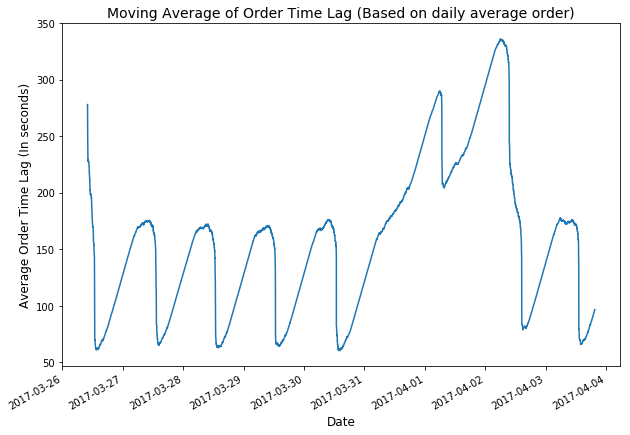

In [9]:
### A visualization on the trend of order time lag (Based on daily average number of orders)

# calculate the average number of orders in this period
daily_average_orders = int(df['Order Create Timestamp'].dt.day.value_counts().mean())

# print the value
print('There are about {} orders per day during this period.'.format(daily_average_orders))

# a plot of the trend (Moving average)
ax = df.set_index('Order Create Timestamp')['order_time_lag'].rolling(daily_average_orders).mean().plot(figsize=(10,7))
ax.set_title('Moving Average of Order Time Lag (Based on daily average order)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Order Time Lag (In seconds)', fontsize=12)
plt.show()

# Statistical Inference

In [10]:
# change plotting style for better visualization
sns.set_style('darkgrid')

## Average Order Match Time

Empirical Average Order Match Time = 48.8912
95% confidence interval = [43.1636  54.99707]


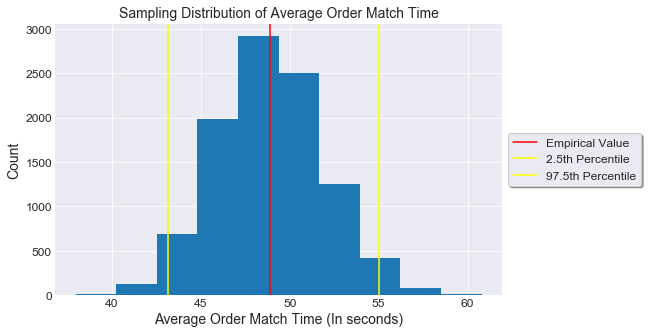

In [11]:
### A sampling distribution of average order match time through bootstrapping (Entire data set)

# the empirical mean order match time
empirical_average = df['total_seconds'].mean()

# generate bootstrapped replicates (average order match time)
bs_average = stats.draw_bs_reps(df['total_seconds'], np.mean, 10000) # 10000 simulations

# 95% confidence interval
conf_int = np.percentile(bs_average, [2.5, 97.5])

# print the results
print('Empirical Average Order Match Time = {}'.format(empirical_average))
print('95% confidence interval = {}'.format(conf_int))

# a detailed histogram of the sampling distribution
stats.sample_distplot(replicates=bs_average, empirical_value=empirical_average,
                     title='Sampling Distribution of Average Order Match Time',
                      xlabel='Average Order Match Time (In seconds)',
                     ylabel='Count')

## Hypothesis Testing on Average Order Match Time (New System v.s Old System)

In [12]:
# create a binary column based on the probabilistic
df['fast_grab'] = 0
df.loc[df['total_seconds'] < empirical_average, 'fast_grab'] = 1

# sanity check on general data cleanliness and readiness
df.info()
print('\n')
print(df.head()) # a glimpse of the first 5 observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
Driver Response Timestamp    5000 non-null datetime64[ns]
Order Create Timestamp       5000 non-null datetime64[ns]
Order Id                     5000 non-null int64
match_time                   5000 non-null timedelta64[ns]
total_seconds                5000 non-null float64
order_time_lag               5000 non-null float64
day_of_week                  5000 non-null category
session                      5000 non-null category
fast_grab                    5000 non-null int64
dtypes: category(2), datetime64[ns](2), float64(2), int64(2), timedelta64[ns](1)
memory usage: 283.8 KB


  Driver Response Timestamp Order Create Timestamp  Order Id match_time  \
0       2017-03-24 22:58:31    2017-03-24 22:57:38         1   00:00:53   
1       2017-03-25 01:04:53    2017-03-25 01:04:53         2   00:00:00   
2       2017-03-25 01:06:16    2017-03-25 01:06:16         3   00:00:00   
3       2

In [13]:
### Split the data based on date (2017-03-30 12:00:00 AM)

# orders placed with old system
old_system = df.loc[df['Order Create Timestamp'] < '2017-03-30 00:00:00', :]

# orders placed with new system
new_system = df.loc[df['Order Create Timestamp'] >= '2017-03-30 00:00:00', :]

# sanity check
print(old_system.tail())
print(new_system.head())

     Driver Response Timestamp Order Create Timestamp  Order Id match_time  \
2593       2017-03-29 18:27:04    2017-03-29 18:26:56      2594   00:00:08   
2594       2017-03-29 18:27:15    2017-03-29 18:27:07      2595   00:00:08   
2595       2017-03-29 18:32:30    2017-03-29 18:32:22      2596   00:00:08   
2596       2017-03-29 18:44:05    2017-03-29 18:43:51      2597   00:00:14   
2597       2017-03-29 19:05:43    2017-03-29 19:05:35      2598   00:00:08   

      total_seconds  order_time_lag day_of_week    session  fast_grab  
2593            8.0           486.0   Wednesday  Afternoon          1  
2594            8.0            11.0   Wednesday  Afternoon          1  
2595            8.0           315.0   Wednesday  Afternoon          1  
2596           14.0           689.0   Wednesday  Afternoon          1  
2597            8.0          1304.0   Wednesday    Evening          1  
     Driver Response Timestamp Order Create Timestamp  Order Id match_time  \
2598       2017-03-30

Empirical Average Order Match Time Difference = 2.15718489659951
95% confidence interval = [-11.66695783  11.85456628]
p-value = 0.6425


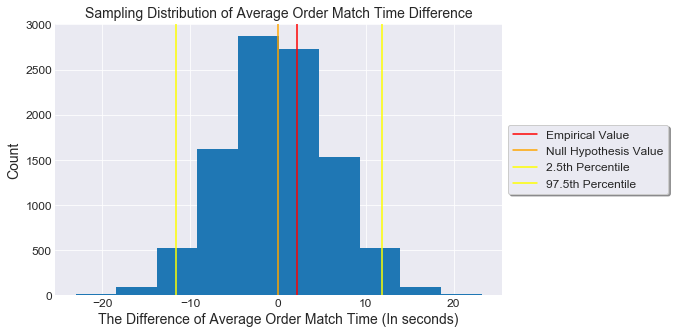

In [14]:
### A sampling distribution of average order match time difference through permutation

# null mean
null_mean = 0

# compute difference of average order match time (New System - Old System)
empirical_diff_means = stats.diff_of_means(new_system['total_seconds'], old_system['total_seconds'])

# draw 10,000 permutation replicates
perm_replicates = stats.draw_perm_reps(new_system['total_seconds'], old_system['total_seconds'],
                                 stats.diff_of_means, size=10000)

# 95% confidence interval
conf_int = np.percentile(perm_replicates, [2.5, 97.5])

# compute p-value
p = np.sum(perm_replicates < empirical_diff_means)/len(perm_replicates)

# Print the result
print('Empirical Average Order Match Time Difference = {}'.format(empirical_diff_means))
print('95% confidence interval = {}'.format(conf_int))
print('p-value =', p)

# a detailed histogram of the sampling distribution
stats.sample_distplot(replicates=perm_replicates, empirical_value=empirical_diff_means,
                     title='Sampling Distribution of Average Order Match Time Difference',
                      xlabel='The Difference of Average Order Match Time (In seconds)',
                     ylabel='Count', null_value=null_mean)

## Hypothesis Testing on Conversion (New System v.s Old System)

Empirical Conversion Difference = -0.02584739814588688
95% confidence interval = [-0.01863632  0.01822032]
p-value = 0.9954


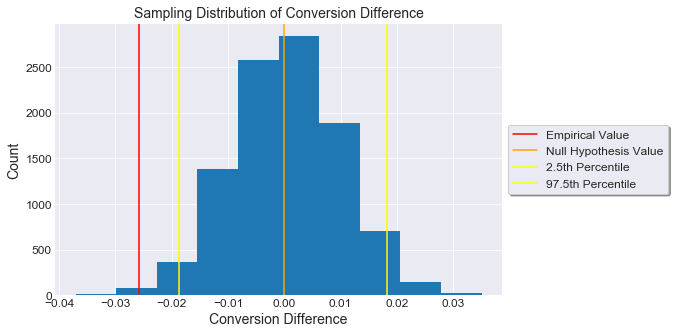

In [15]:
# compute difference of conversion (A fast grab)
empirical_diff_means = stats.diff_of_means(new_system['fast_grab'], old_system['fast_grab'])

# draw 10,000 permutation replicates
perm_replicates = stats.draw_perm_reps(new_system['fast_grab'], old_system['fast_grab'],
                                 stats.diff_of_means, size=10000)

# 95% confidence interval
conf_int = np.percentile(perm_replicates, [2.5, 97.5])

# compute p-value
p = np.sum(perm_replicates > empirical_diff_means)/len(perm_replicates)

# Print the result
print('Empirical Conversion Difference = {}'.format(empirical_diff_means))
print('95% confidence interval = {}'.format(conf_int))
print('p-value =', p)


# a detailed histogram of the sampling distribution
stats.sample_distplot(replicates=perm_replicates, empirical_value=empirical_diff_means,
                     title='Sampling Distribution of Conversion Difference',
                      xlabel='Conversion Difference',
                     ylabel='Count', null_value=null_mean)

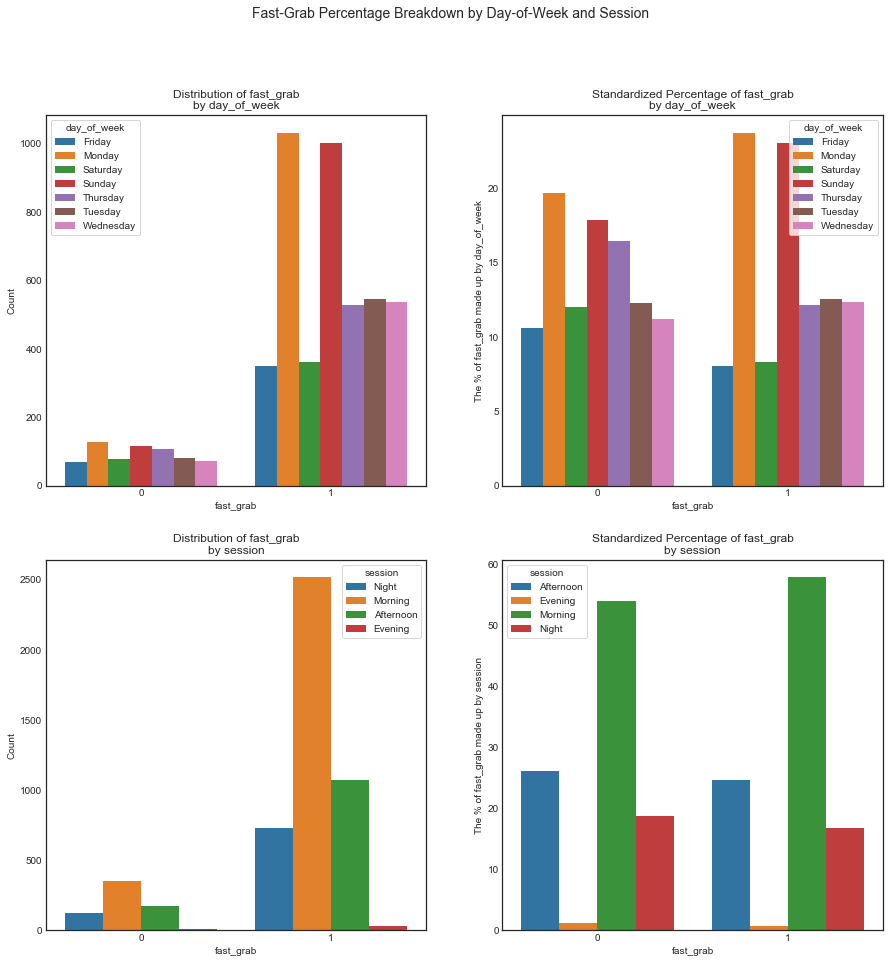

In [16]:
### A visualization of fast grab percentage breakdown by day of week and session

# change style for better visualization
sns.set_style('white')

# axes and hue
x = 'fast_grab'
hue1 = 'day_of_week'
hue2 = 'session'

# plot
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.countplot(x=x, hue=hue1, data=df, ax=axes[0,0])
axes[0,0].set_title('Distribution of {}\nby {}'.format(x, hue1))
axes[0,0].set_ylabel("Count")
axes[0,0].legend(title=hue1, frameon=True)
stats.pct_std_barplot(x=x, y='Percentage', hue=hue1, data=df, ax=axes[0,1])
axes[0,1].set_title('Standardized Percentage of {}\nby {}'.format(x, hue1))
axes[0,1].set_ylabel('The % of {} made up by {}'.format(x, hue1))
axes[0,1].legend(title=hue1, frameon=True)
sns.countplot(x=x, hue=hue2, data=df, ax=axes[1,0])
axes[1,0].set_title('Distribution of {}\nby {}'.format(x, hue2))
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title=hue2, frameon=True)
stats.pct_std_barplot(x=x, y='Percentage', hue=hue2, data=df, ax=axes[1,1])
axes[1,1].set_title('Standardized Percentage of {}\nby {}'.format(x, hue2))
axes[1,1].set_ylabel('The % of {} made up by {}'.format(x, hue2))
axes[1,1].legend(title=hue2, frameon=True)

# figure parameters
fig.suptitle('Fast-Grab Percentage Breakdown by Day-of-Week and Session', fontsize=14) # title
plt.show()

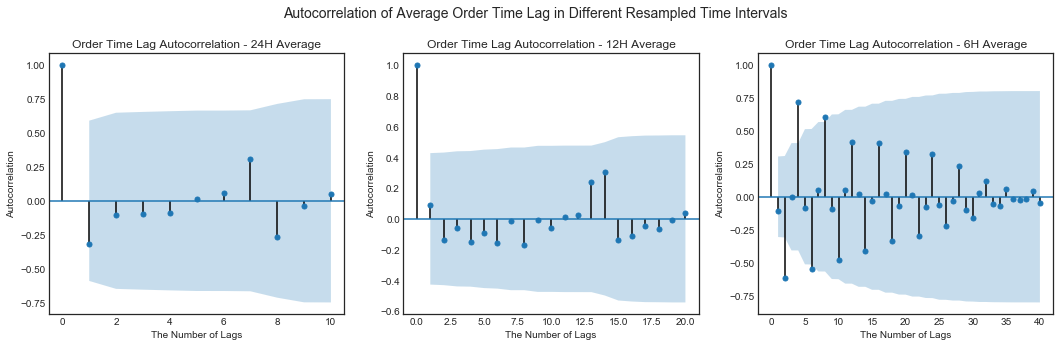

In [17]:
### Explore to see if there is any autocorrelation

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot parameters
frequencies = ['24H', '12H', '6H']

# a loop for visualization
for idx, freq in enumerate(frequencies):
    resampled_time_lag = df.set_index('Order Create Timestamp')['order_time_lag'].resample(freq).mean()
    acf = plot_acf(resampled_time_lag, alpha=0.05, ax=axes[idx])
    axes[idx].set_title('Order Time Lag Autocorrelation - {} Average'.format(freq))
    axes[idx].set_xlabel('The Number of Lags')
    axes[idx].set_ylabel('Autocorrelation')

# figure parameters
fig.suptitle('Autocorrelation of Average Order Time Lag in Different Resampled Time Intervals', fontsize=14) # title
fig.subplots_adjust(top=0.85) # adjust figure's title location
plt.show()

In [18]:
### Run regression test to see if average order time lag is a random walk

# regression test for random walk on average order time lag
results = adfuller(df.set_index('Order Create Timestamp')['order_time_lag'].resample('6H').mean())

# print the p-value
print('The p-value of the test on average order time lag (6-Hour) is: {}'.format(round(results[1], 4)))

The p-value of the test on average order time lag (6-Hour) is: 0.4464


In [19]:
# create a copy for modelling
df_model = df.copy()

# create an intercept
df_model = sm.add_constant(df_model)

# turn categorical variables into dummy variables (Columns)
df_model = pd.get_dummies(df_model)

# sanity check
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
const                        5000 non-null float64
Driver Response Timestamp    5000 non-null datetime64[ns]
Order Create Timestamp       5000 non-null datetime64[ns]
Order Id                     5000 non-null int64
match_time                   5000 non-null timedelta64[ns]
total_seconds                5000 non-null float64
order_time_lag               5000 non-null float64
fast_grab                    5000 non-null int64
day_of_week_Friday           5000 non-null uint8
day_of_week_Monday           5000 non-null uint8
day_of_week_Saturday         5000 non-null uint8
day_of_week_Sunday           5000 non-null uint8
day_of_week_Thursday         5000 non-null uint8
day_of_week_Tuesday          5000 non-null uint8
day_of_week_Wednesday        5000 non-null uint8
session_Night                5000 non-null uint8
session_Morning              5000 non-null uint8
session_Afternoon         

In [20]:
### A logistic model to infer whether certain day of week or session 

# construct a list of independent variables + intercept
model_int_vars = df_model.columns[-11:].tolist() + ['const']

# construct logistic model (Drop Friday and Evening (2 dummy columns) to achieve full rank matrices)
logistic_model = sm.Logit(df_model['fast_grab'],
                          df_model[model_int_vars].drop(['day_of_week_Friday', 'session_Evening'], axis=1))

# fit the model
results = logistic_model.fit()

print(results.summary())
print('\n')

# odd ratios and corresponding confidence interval
print('The Odd Ratio and Corresponding Confidence Interval (95%):')
stats_params = results.params
conf_int = results.conf_int()
conf_int['odd_ratios'] = stats_params
conf_int.columns = ['2.5%', '97.5%', 'odd_ratios']
print(np.exp(conf_int))

Optimization terminated successfully.
         Current function value: 0.383189
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              fast_grab   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4990
Method:                           MLE   Df Model:                            9
Date:                Tue, 03 Jul 2018   Pseudo R-squ.:                0.009249
Time:                        18:55:31   Log-Likelihood:                -1915.9
converged:                       True   LL-Null:                       -1933.8
                                        LLR p-value:                 4.350e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
day_of_week_Monday        0.4627      0.162      2.860      0.004       0.146       0.

# Building Supervised Learning Model

In [21]:
# Import sklearn tools and models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import ml # a script of classifier building pipeline

# inputs preprocessing
features = df.drop(['fast_grab', 'total_seconds', 'order_time_lag'], axis=1)
features['month'] = features['Order Create Timestamp'].dt.month.astype('category')
features['day'] = features['Order Create Timestamp'].dt.day.astype('category')
features['hour'] = features['Order Create Timestamp'].dt.hour.astype('category')
features['minute'] = features['Order Create Timestamp'].dt.minute.astype('category')

# labels - target variables
labels_cls = df['fast_grab']

# sanity check
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
Driver Response Timestamp    5000 non-null datetime64[ns]
Order Create Timestamp       5000 non-null datetime64[ns]
Order Id                     5000 non-null int64
match_time                   5000 non-null timedelta64[ns]
day_of_week                  5000 non-null category
session                      5000 non-null category
month                        5000 non-null category
day                          5000 non-null category
hour                         5000 non-null category
minute                       5000 non-null category
dtypes: category(6), datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 190.4 KB


In [22]:
# slice the features needed
features_final = features.loc[:, 'day_of_week':]

# create dummy variables for all categorical variables (One-hot-encoding)
features_final_cls = pd.get_dummies(features_final)

# sanity check
features_final_cls.head()

,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,session_Night,session_Morning,session_Afternoon,...,minute_50,minute_51,minute_52,minute_53,minute_54,minute_55,minute_56,minute_57,minute_58,minute_59
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# split the features and labels data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_final_cls, 
                                                    labels_cls, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

# show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3750 samples.
Testing set has 1250 samples.


In [24]:
# prepare models
cls_models = []
cls_models.append(('Multinominal Naive Bayes', MultinomialNB()))
cls_models.append(('AdaBoost', AdaBoostClassifier()))
cls_models.append(('Gradient Boosting', GradientBoostingClassifier()))
cls_models.append(('Random Forest', RandomForestClassifier()))
cls_models.append(('Logistic Regression', LogisticRegression()))

# print models parameters
for name, model in cls_models:
    print(name)
    print(model.get_params())
    print('\n')

Multinominal Naive Bayes
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


AdaBoost
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}


Gradient Boosting
{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


Random Forest
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'w

The average f-1 score and standard deviation of each model is:
Multinominal Naive Bayes: 0.9299 (0.0118)
AdaBoost: 0.9285 (0.0115)
Gradient Boosting: 0.9298 (0.0091)
Random Forest: 0.9234 (0.0086)
Logistic Regression: 0.9378 (0.0099)


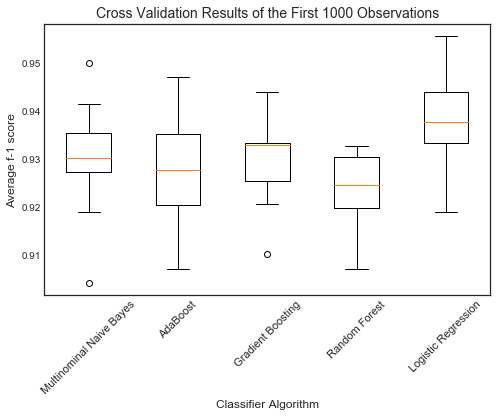

In [25]:
### A high level evaluation of algorithms

# hyperparameters for GB and RF
#max_depth = [2, 4, 6]
#n_estimators = [10, 100, 1000]

# a dictionary to be fed into grid search
#params = dict(max_depth=max_depth, n_estimators=n_estimators)

# evaluate each model
cls_results = []
cls_names = []
cls_estimators = []

print('The average f-1 score and standard deviation of each model is:')
for name, model in cls_models:
    # define parameters if grid search is needed
    cv_results, best_estimators = ml.fit_classifier(X_train, y_train, model, parameters=None)
    cls_results.append(cv_results)
    cls_names.append(name)
    cls_estimators.append(best_estimators)
    average = '{}: {} ({})'.format(name, round(cv_results.mean(), 4), round(cv_results.std(), 4))
    print(average)

# algorithm comparison illustrated in a boxplot
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(cls_results)
ax.set_title('Cross Validation Results of the First 1000 Observations', fontsize=14)
ax.set_xticklabels(cls_names, fontsize=11, rotation=45)
ax.set_xlabel('Classifier Algorithm', fontsize=12)
ax.set_ylabel('Average f-1 score', fontsize=12)
plt.show()

In [26]:
### algorithms performance on test set

# a loop for printing performance summary
for name, estimator in zip(cls_names, cls_estimators):
    print('The {} model performance:'.format(name))
    print(classification_report(y_test, estimator.predict(X_test), target_names=['Not Fast-Grab', 'Fast-Grab']))
    print('\n')

The Multinominal Naive Bayes model performance:
               precision    recall  f1-score   support

Not Fast-Grab       0.19      0.02      0.03       159
    Fast-Grab       0.87      0.99      0.93      1091

  avg / total       0.79      0.86      0.81      1250



The AdaBoost model performance:
               precision    recall  f1-score   support

Not Fast-Grab       0.43      0.02      0.04       159
    Fast-Grab       0.87      1.00      0.93      1091

  avg / total       0.82      0.87      0.82      1250



The Gradient Boosting model performance:
               precision    recall  f1-score   support

Not Fast-Grab       0.20      0.02      0.03       159
    Fast-Grab       0.87      0.99      0.93      1091

  avg / total       0.79      0.87      0.81      1250



The Random Forest model performance:
               precision    recall  f1-score   support

Not Fast-Grab       0.14      0.08      0.10       159
    Fast-Grab       0.87      0.93      0.90      1091

